#__CLTV Prediction on FLO Retail Dataset with BG-NBD and Gamma-Gamma__

##__Business Problem__

FLO wants to define a roadmap for its sales and marketing activities.
In order for the company to make medium- and long-term plans, it is necessary to estimate  the potential value that existing customers will provide to the company in the future.


__Story of Dataset__

The dataset consists of information obtained from the past shopping behaviors of customers who made their last purchases as OmniChannel (shopping both online and offline) in 2020 and 2021.

__Variables__

master_id: Unique customer ID
order_channel: The channel of the platform where the purchase was made (Android, iOS, Desktop, Mobile, Offline)
last_order_channel: The channel of the most recent purchase
first_order_date: The date of the customer's first purchase
last_order_date: The date of the customer's most recent purchase
last_order_date_online: The date of the customer's most recent online purchase
last_order_date_offline: The date of the customer's most recent offline purchase
order_num_total_ever_online: Total number of purchases made by the customer on the online platform
order_num_total_ever_offline: Total number of purchases made by the customer on the offline platform
customer_value_total_ever_offline: Total amount paid by the customer in offline purchases
customer_value_total_ever_online: Total amount paid by the customer in online purchases
interested_in_categories_12: List of categories the customer shopped in during the last 12 months

##__Data Preperation__

__Required Libraries and Functions__

In [69]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.05)
    quartile3 = dataframe[variable].quantile(0.95)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    # dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [34]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib
from sympy.abc import lamda

matplotlib.use("TkAgg")
%matplotlib inline
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
import seaborn as sns
pd.set_option("display.max_columns",None)
pd.set_option("display.width",500)


Loading the Data

In [70]:
df_ = pd.read_csv(r"C:\Users\OGUZ HOME\data_sets\flo_data_20k.csv")
df = df_.copy()

In [71]:
df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.00,1.00,139.99,799.38,[KADIN]
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.00,2.00,159.97,1853.58,"[ERKEK, COCUK, KADIN, AKTIFSPOR]"
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.00,2.00,189.97,395.35,"[ERKEK, KADIN]"
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.00,1.00,39.99,81.98,"[AKTIFCOCUK, COCUK]"
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.00,1.00,49.99,159.99,[AKTIFSPOR]


In [8]:
df.isnull().sum()

master_id                            0
order_channel                        0
last_order_channel                   0
first_order_date                     0
last_order_date                      0
last_order_date_online               0
last_order_date_offline              0
order_num_total_ever_online          0
order_num_total_ever_offline         0
customer_value_total_ever_offline    0
customer_value_total_ever_online     0
interested_in_categories_12          0
dtype: int64

In [9]:
df.dtypes

master_id                             object
order_channel                         object
last_order_channel                    object
first_order_date                      object
last_order_date                       object
last_order_date_online                object
last_order_date_offline               object
order_num_total_ever_online          float64
order_num_total_ever_offline         float64
customer_value_total_ever_offline    float64
customer_value_total_ever_online     float64
interested_in_categories_12           object
dtype: object

The variables representing dates are currently of type object. We need to convert them to datetime format.

In [77]:
for col in df.columns:
    if "date" in col:
        df[col] = pd.to_datetime(df[col])

In [78]:
df.dtypes

master_id                                    object
order_channel                                object
last_order_channel                           object
first_order_date                     datetime64[ns]
last_order_date                      datetime64[ns]
last_order_date_online               datetime64[ns]
last_order_date_offline              datetime64[ns]
order_num_total_ever_online                 float64
order_num_total_ever_offline                float64
customer_value_total_ever_offline           float64
customer_value_total_ever_online            float64
interested_in_categories_12                  object
dtype: object

In [72]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
order_num_total_ever_online,19945.00,3.11,4.23,1.00,1.00,2.00,4.00,200.00
order_num_total_ever_offline,19945.00,1.91,2.06,1.00,1.00,1.00,2.00,109.00
customer_value_total_ever_offline,19945.00,253.92,301.53,10.00,99.99,179.98,319.97,18119.14
customer_value_total_ever_online,19945.00,497.32,832.60,12.99,149.98,286.46,578.44,45220.13


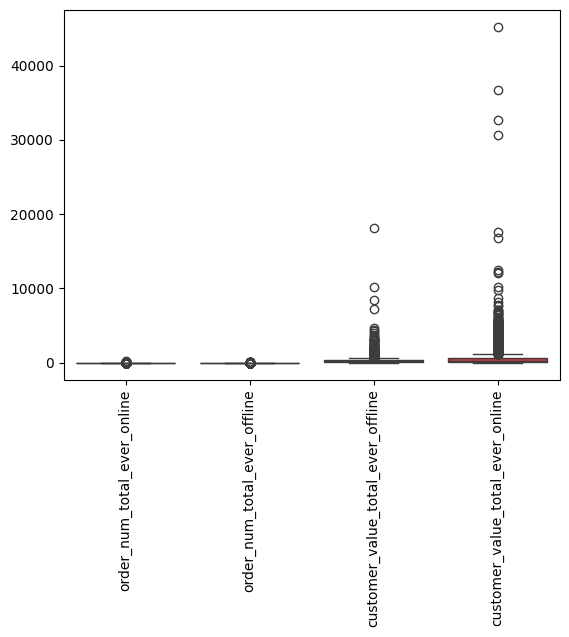

In [73]:
num_cols = [col for col in df.columns if df[col].dtype in ["int","float"]]
sns.boxplot(df[num_cols])
plt.xticks(rotation=90)  
plt.show()

When we examine the summary statistics of the dataset, we observe that the variables `customer_value_total_ever_offline` and `customer_value_total_ever_online` have high standard deviations. Additionally, the boxplot reveals the presence of significant outliers.
By capping extreme values, we ensure a more balanced data distribution, leading to more stable and reliable analysis results.

In [74]:
for col in df.columns:
    if "customer" in col:
        replace_with_thresholds(df,col)  

In [75]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
order_num_total_ever_online,19945.00,3.11,4.23,1.00,1.00,2.00,4.00,200.00
order_num_total_ever_offline,19945.00,1.91,2.06,1.00,1.00,1.00,2.00,109.00
customer_value_total_ever_offline,19945.00,249.74,233.36,10.00,99.99,179.98,319.97,1675.57
customer_value_total_ever_online,19945.00,481.27,568.28,12.99,149.98,286.46,578.44,3795.83


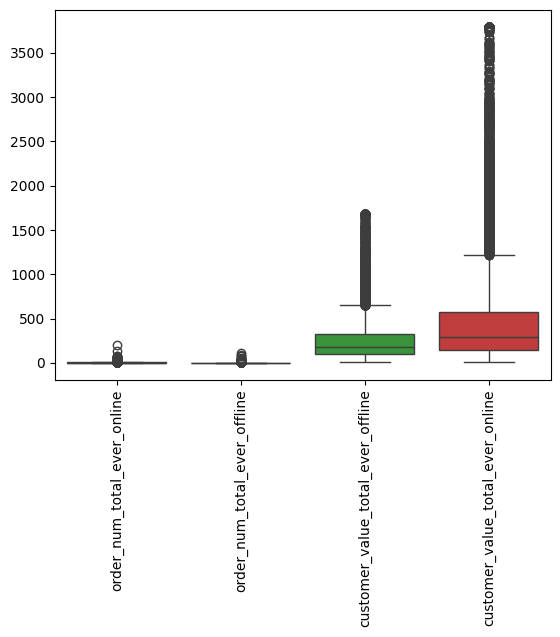

In [76]:
num_cols = [col for col in df.columns if df[col].dtype in ["int","float"]]
sns.boxplot(df[num_cols])
plt.xticks(rotation=90)  
plt.show()